Question 1:


R_squared (r2) value: 0.0061896609969190886
Correlation Coefficent: 0.07867439861173972
Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:           ftse_returns   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.308
Date:                Tue, 15 Oct 2024   Prob (F-statistic):              0.254
Time:                        23:45:38   Log-Likelihood:                 346.42
No. Observations:                 212   AIC:                            -688.8
Df Residuals:                     210   BIC:                            -682.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------

C:\Users\Mark Ahugari\AppData\Local\Temp\ipykernel_46008\596080308.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  house_ftse_df.fillna(method='ffill', inplace=True)


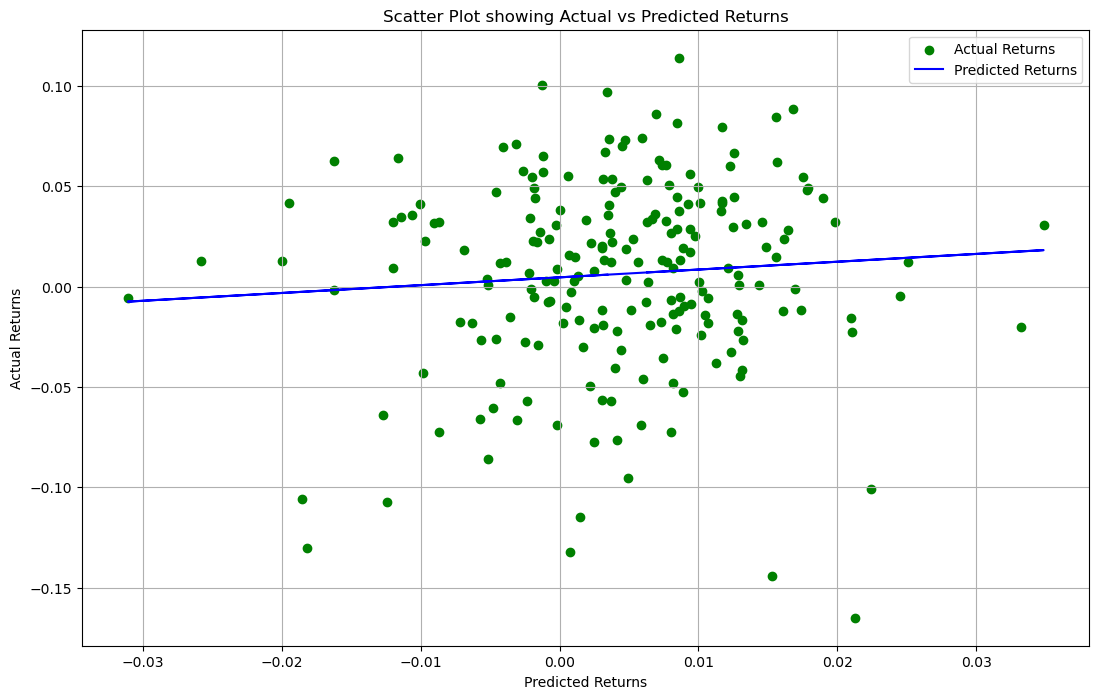

P-value from F-test: 0.25407278663659916
Conclusion: No significant relationship is found between FTSE100 index returns and 
house prices returns.


In [707]:
# to use read_excel function
import pandas as pd
# to plot and configure graphs
import matplotlib.pyplot as plt
# to utilize correlation function
import numpy as np
# to utilize the fit (model) function
from sklearn.linear_model import LinearRegression as lr

import statsmodels.api as st

# storing data from data source into respective data frames (both metadata and original data) 
ftse100_df = pd.read_csv('data/FTSE100.csv')
houseprices_df = pd.read_excel('data/Monthly.xls')

ftse100_df['Date'] = pd.to_datetime(ftse100_df['Date'])
houseprices_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
houseprices_df['Date'] = pd.to_datetime(houseprices_df['Date'])
ftse100_df = ftse100_df.drop(columns=['Open', 'Close', 'High', 'Low', 'Volume'])
# houseprices_df= houseprices_df.drop(columns=['Seasonally Adjusted Index','Monthly % Change (SA)',  'Year % Change', 'Latest 3 months on previous 3 months', 'INDEX Q1 1993=100'])
houseprices_df= houseprices_df.drop(columns=['Seasonally Adjusted Index','Average House Price',  'Year % Change', 'Latest 3 months on previous 3 months', 'INDEX Q1 1993=100'])

houseprices_df.set_index('Date', inplace=True)
houseprices_df = houseprices_df[houseprices_df.index <= '2016']
house_ftse_df = pd.merge(ftse100_df, houseprices_df, on='Date')
house_ftse_df.set_index('Date', inplace=True)
house_ftse_df.sort_index(inplace=True)

# print(ftse100_df.head(5))

house_ftse_df.fillna(method='ffill', inplace=True)
# print(house_ftse_df.isnull ().sum())

# define the dependent and independent variables
# taking the last price of each month after resampling
# dp_var = ftse100_df['Adj Close'].resample('M').last()
house_ftse_df['house_returns'] = house_ftse_df['Monthly % Change (SA)']
house_ftse_df['ftse_returns'] = house_ftse_df['Adj Close'].pct_change()

house_ftse_df.dropna(inplace=True)

# print(house_ftse_df.head(5))

# Y for the dependent variable
Y = house_ftse_df['ftse_returns']
# X for the explanatory variable
X_full = house_ftse_df['house_returns']


# # fitting the model
# model = lr()
# model.fit(X_full,Y)

# # get coefficients
# slope = model.coef_[0]
# intercept = model.intercept_
# predictions = model.predict(X_full)

# print(f"slope: {slope}, intercept: {intercept}")

X_with_const = st.add_constant(X_full)
model_stats = st.OLS(Y, X_with_const).fit()

# get r value
# r_squared = model.score(X_full, Y)
print(f"R_squared (r2) value: {model_stats.rsquared}")

correlation_coefficient = np.corrcoef(house_ftse_df['house_returns'], house_ftse_df['ftse_returns'])[0, 1]
print(f"Correlation Coefficent: {correlation_coefficient}")

print("Regression Model Summary:")
print(model_stats.summary())

# graph configuration
plt.figure(figsize=(13,8))
plt.scatter(X_full,Y, color='green', label='Actual Returns')
plt.plot(X_full, predictions, color='blue', label='Predicted Returns')
plt.title("Scatter Plot showing Actual vs Predicted Returns")
plt.ylabel("Actual Returns")
plt.xlabel("Predicted Returns")
plt.grid()
plt.legend()
plt.show()


# Hypothesis testing:  using f-test for overall model significance

# Null Hypothesis (H0): There is no significant relationship between the FTSE100 index monthly returns and house prices monthly returns.
# Alternative Hypothesis (Ha): A significant relationship exists between the two variables.


r_matrix = np.array([[0,1]]) # 2x1 array to match shape of model 
ftest = model_stats.f_test(r_matrix)
fstatistic = ftest.statistic
fp_value = ftest.pvalue

significance_level = 0.05

print("P-value from F-test:", fp_value)

if fp_value < significance_level:
    conclusion = "There is a significant relationship between FTSE100 index returns and \nhouse prices returns."
else:
    conclusion = "No significant relationship is found between FTSE100 index returns and \nhouse prices returns."

print("Conclusion:", conclusion)





Question 2:


In [660]:
# to utilize the plot function 
import pandas as pd
# to plot and configure graphs
import matplotlib.pyplot as plt

# to utilize the OLS
import statsmodels.api as st 

from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression as lr

from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

# reading data from csv file
college_df = pd.read_csv('data/college.csv')
college_df.rename(columns={'Unnamed: 0': 'Institution'}, inplace=True)
# filter useful columns
college_df_filtered = college_df[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc', 'Grad.Rate']]

res= college_df_filtered.corr()
print(f"Correlation Coefficients for variables:\n {res}")
college_df_filtered = college_df_filtered.drop(columns=['Grad.Rate'])

# get correlation coefficient between pairs of filtered columns 
# define dependent variable 
Y = college_df['Grad.Rate']
# define independent variables
X_full = college_df_filtered
# add constant term to independent variable
X_full = st.add_constant(X_full)


def backward_elimination(model, X,Y):
    while True:
        # exclude the intercept while saving pvalues
        pvalues = model.pvalues[1:]
        max_pvalue = pvalues.max()
        if max_pvalue < 0.05:
            break
        predictor_to_remove = pvalues.idxmax()
        X = X.drop(columns=[predictor_to_remove])
        model = st.OLS(Y,X).fit()
    return model

# fit initial model with predictors
model = st.OLS(Y,X_full).fit()
print("\n Default model summary:\n",model.summary())

final_model = backward_elimination(model,X_full, Y)
predictors = final_model.pvalues.index.tolist()
print(f"Useful Predictors found: {predictors[1:]}")




# fit different models
# new dataframe with just useful predictors
X_df_bic = college_df_filtered[predictors[1:]]
X_df_bic = st.add_constant(X_df_bic)

# fit the BIC model
bic_model = st.OLS(Y, X_df_bic).fit()

print("\n BIC Model Summary:\n", bic_model.summary())



# fit different models
# BIC for full model
# model accuracy comparison

# splitting data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_df_bic, Y, test_size=0.2, random_state=42)

# fitting stepwise to training data
stepwise_model = st.OLS(Y_train, X_train).fit()

# predict the graduation rate
Y_pred_bic = bic_model.predict(st.add_constant(X_test))
Y_pred_stepwise = stepwise_model.predict(st.add_constant(X_test))

acc_bic= r2_score(Y_test, Y_pred_bic)
acc_stepwise= r2_score(Y_test, Y_pred_stepwise)

print(f"\nAccuracy of BIC Model: {acc_bic:.2f}")
print(f"Accuracy of Stepwise Model with Useful Variables: {acc_stepwise:.2f}")

# BIC for useful predictors model
X_useful = X_full[predictors]
model_useful =st.OLS(Y, X_useful).fit()
# bic_usefull = n * np.log(model_useful.mse_resid) + len(model_useful.params) * np.log(n)
# print(f"BIC for useful model: {bic_usefull}")



# predictions for both models
# prediction for full model
predictions_full = model.predict(X_full)
# prediction for useful predictor model
predictions_useful = model_useful.predict(X_useful)

# calculate RMSE
mse_full = mse(Y, predictions_full)
mse_useful = mse(Y, predictions_useful)
print(f"MSE Full Model (All predictors): {mse_full},\n MSE Useful Model (Significant predictors): {mse_useful}")


# prediction for carnegie mellon university
cmu_df = college_df[college_df['Institution'] == 'Carnegie Mellon University'].copy()
cmu_df['const'] = 1.0
cmu_df = cmu_df[predictors]
predicted_cmu_rate = model_useful.predict(cmu_df)

print(f"Predicted CMU Graduation Rate: {predicted_cmu_rate.values}")



Correlation Coefficients for variables:
                Apps    Enroll  Outstate  Top10perc  Top25perc  Grad.Rate
Apps       1.000000  0.846822  0.050159   0.338834   0.351640   0.146755
Enroll     0.846822  1.000000 -0.155477   0.181294   0.226745  -0.022341
Outstate   0.050159 -0.155477  1.000000   0.562331   0.489394   0.571290
Top10perc  0.338834  0.181294  0.562331   1.000000   0.891995   0.494989
Top25perc  0.351640  0.226745  0.489394   0.891995   1.000000   0.477281
Grad.Rate  0.146755 -0.022341  0.571290   0.494989   0.477281   1.000000

 Default model summary:
                             OLS Regression Results                            
Dep. Variable:              Grad.Rate   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     97.00
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           2.73e-79
Time:                      

Question 3:


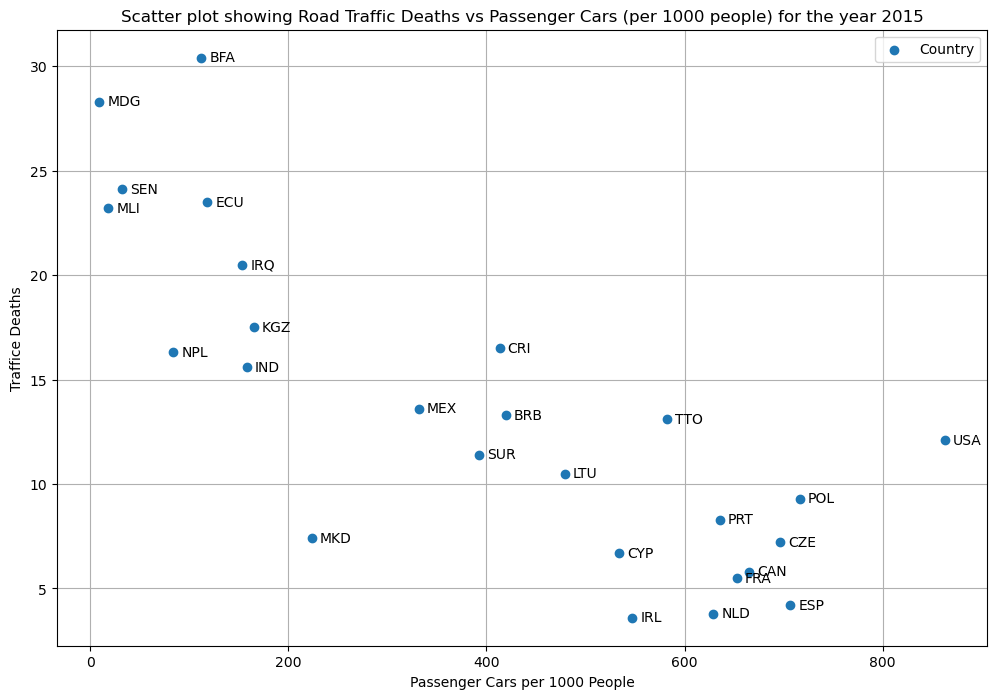

Correlation coefficent: -0.8088205151673584
                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     45.40
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           5.72e-07
Time:                        23:30:35   Log-Likelihood:                -75.653
No. Observations:                  26   AIC:                             155.3
Df Residuals:                      24   BIC:                             157.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

In [706]:
# to utilize the read_excel function
import pandas as pd

# to plot graphs
import matplotlib.pyplot as plt

import statsmodels.api as st

# read data from file
drate_df = pd.read_csv('data/death_rate_road.csv')
rvehicles_df = pd.read_csv('data/registered_vehicles.csv')

# print(drate_df.head(5))
# print(rvehicles_df.head(5))
drate_df = drate_df.rename(columns={'3.6.1 - Death rate due to road traffic injuries, by sex (per 100,000 population) - SH_STA_TRAF - Both sexes': 'Deaths'})
drate_df.drop(columns=['Entity'], inplace=True)
drate_df = drate_df[drate_df['Year'] == 2015]
# print(drate_df)

rvehicles_df = rvehicles_df.rename(columns={'Registered vehicles per 1,000 people': 'Vehicles'})
rvehicles_df.drop(columns=['Entity'], inplace=True)
rvehicles_df = rvehicles_df[rvehicles_df['Year'] == 2015]
# print(rvehicles_df)

dr_rv_df= pd.merge( rvehicles_df,drate_df, on='Code')
# dr_rv_df.drop(columns=['Year'], inplace=True)

# print(dr_rv_df)

plt.figure(figsize=(12,8))
plt.title('Scatter plot showing Road Traffic Deaths vs Passenger Cars (per 1000 people) for the year 2015')
plt.scatter(dr_rv_df['Vehicles'], dr_rv_df['Deaths'], marker='o', label="Country")
# plt.plot(X, future_df['predicted_deaths'], color='red', label='Predictions for 2021')
plt.xlabel('Passenger Cars per 1000 People')
plt.ylabel('Traffice Deaths')
for index, row in dr_rv_df.iterrows():
    plt.annotate(row['Code'], (row['Vehicles'], row['Deaths']), fontsize=10, ha='left', xytext=(8,-4), textcoords='offset pixels')
plt.grid()
plt.legend()
plt.show()


#  
correlation = dr_rv_df['Vehicles'].corr(dr_rv_df['Deaths'])
print(f"Correlation coefficent: {correlation}")

# define independent and dependent variables
X_full = dr_rv_df['Vehicles']
Y = dr_rv_df['Deaths']

# constant for intercept
X_full = st.add_constant(X_full)

# fit regression model
model = st.OLS(Y, X_full).fit()
print(model.summary())

# predicting traffic death
# predictions = model.predict(X)
# dr_rv_df['predicted_deaths'] = predictions

# print(dr_rv_df[['Deaths', 'Vehicles', 'predicted_deaths']])

# assuming a 2% increase of vehicles in 2021 
projected_cars_per_1000 = dr_rv_df['Vehicles'] * (1+0.02) ** (2021 - 2015) 

# 
future_df = pd.DataFrame({
                        'Code': dr_rv_df['Code'],
                        'projected_vehicles': projected_cars_per_1000
                        })

# 
future_x = st.add_constant(future_df['projected_vehicles'])
future_df['predicted_deaths'] = model.predict(future_x)

# display predictions
print(dr_rv_df.head(5))

print(future_df.head(5))

# plt.figure(figsize=(12,8))
# plt.title('Scatter plot showing prediction of Road Traffic Deaths vs Passenger Cars (per 1000 people) for the year 2021')
# plt.scatter(future_df['projected_vehicles'], future_df['predicted_deaths'], marker='o', label="Country")
# # plt.plot(X, future_df['predicted_deaths'], color='red', label='Predictions for 2021')
# plt.xlabel('Passenger Cars per 1000 People')
# plt.ylabel('Traffice Deaths')
# for index, row in future_df.iterrows():
#     plt.annotate(row['Code'], (row['projected_vehicles'], row['predicted_deaths']), fontsize=10, ha='left', xytext=(8,-4), textcoords='offset pixels')
# plt.grid()
# plt.legend()
# plt.show()
print(future_df)




Question 4:


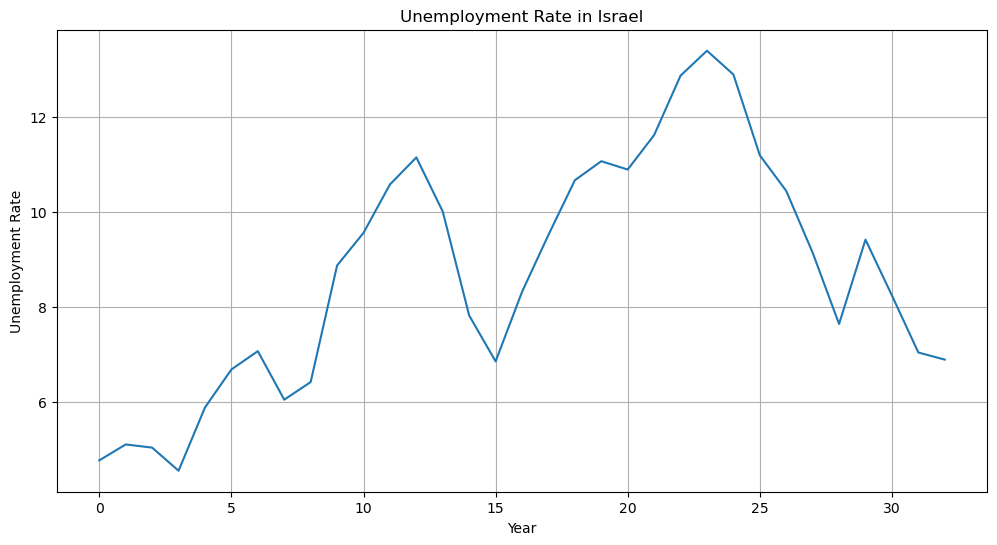

Predicted Graduation Rate for the year 2020: 12.08
                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     12.81
Date:                Tue, 15 Oct 2024   Prob (F-statistic):            0.00116
Time:                        23:21:20   Log-Likelihood:                -70.831
No. Observations:                  33   AIC:                             145.7
Df Residuals:                      31   BIC:                             148.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [704]:
# to utilize the read_excel function
import pandas as pd
# to utilize the arange function
import numpy as np
# to configure and plot graphs
import matplotlib.pyplot as plt

import statsmodels.api as st

# save data from file into dataframe
unemployment_df = pd.read_csv('data/israeli_unemployment_rate.csv')

unemployment_df['Date'] = pd.to_datetime(unemployment_df['Date']).dt.year
# filter the dataframe
unemployment_df = unemployment_df[unemployment_df['Date'] < 2013]
# print(unemployment_df.tail(5))


# Plot the unemployment rate over time
plt.figure(figsize=(12, 6))
plt.plot(unemployment_df.index, unemployment_df['Value'])
plt.title('Unemployment Rate in Israel')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.show()

# print(np.asarray(unemployment_df))

# define independent variable and dependent variable
X = unemployment_df['Date']
# dependent variable
Y = unemployment_df['Value']

# add a constant to the model (intercept)
X = st.add_constant(X)

# fitting the model
model = st.OLS(Y,X).fit()

# predict graduation rate for the year 2020
pred_2020 = pd.DataFrame({'const':[1], 'Year': [2020]})
pred_rate_2020 = model.predict(pred_2020)

print(f"Predicted Graduation Rate for the year 2020: {pred_rate_2020[0]:.2f}")

# evaluate accuracy of the model by getting model summary
# calculate the R2 value using
print(model.summary())

actual_rate_2020  = 12.0
accuracy = (1 - abs(pred_rate_2020[0] - actual_rate_2020) / actual_rate_2020) * 100

print(f"Accuracy as %age: {accuracy:.2f}%")
